In [ ]:
import pandas as pd
import numpy as np
import tensorflow.keras
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import h5py
import cv2
import scipy
from scipy.spatial.distance import cosine
from google.colab.patches import cv2_imshow

In [ ]:
from tensorflow.keras.layers import Flatten, Dense, Input,concatenate
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Activation, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
import tensorflow as tf

In [ ]:
vgg16 = tf.keras.applications.VGG16(weights='imagenet', include_top=True, pooling='max', input_shape=(224, 224, 3))

553467904/553467096 [==============================] - 3s 0us/step


In [ ]:
basemodel = Model(inputs=vgg16.input, outputs=vgg16.get_layer('fc2').output)

In [ ]:
basemodel.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [ ]:
def get_feature_vector(img):
  img1 = cv2.resize(img, (224, 224))
  feature_vector = basemodel.predict(img1.reshape(1, 224, 224, 3))
  return feature_vector

In [ ]:
def calculate_similarity(vector1, vector2):
  return 1-cosine(vector1, vector2)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


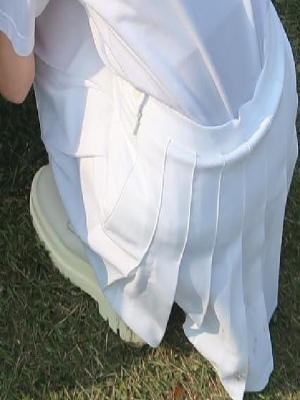

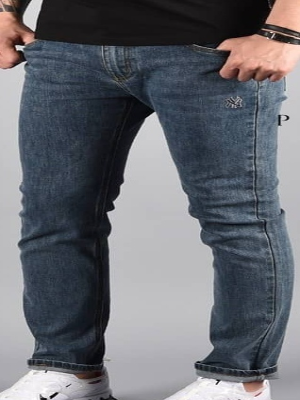

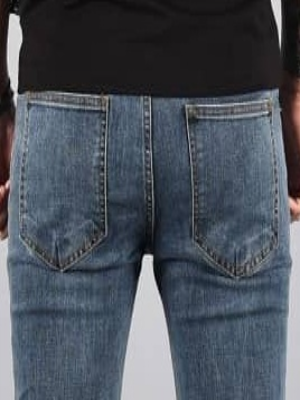

0.2620216906070709
0.198784738779068
[[3.156547  0.        0.        ... 0.4274795 1.2086413 0.       ]]


In [ ]:
img1 = cv2.imread("/content/drive/MyDrive/play data final project/insta_imgcrop/img1000_b0_c7.jpg")
img2 = cv2.imread("/content/drive/MyDrive/play data final project/insta_imgcrop/img1001_b0_c7.jpg")
img3 = cv2.imread("/content/drive/MyDrive/play data final project/insta_imgcrop/img1001_b1_c7.jpg")
f1 = get_feature_vector(img1)
f2 = get_feature_vector(img2)
f3 = get_feature_vector(img3)

cv2_imshow(cv2.resize(img1, (300,400)))
cv2_imshow(cv2.resize(img2, (300,400)))
cv2_imshow(cv2.resize(img3, (300,400)))
print(calculate_similarity(f1, f2)) # 0.7384121417999268)
print(calculate_similarity(f1, f3)) # 0.48573723435401917)
print(f1)

In [ ]:
import os

In [ ]:
cropped_dir = '/content/drive/MyDrive/play data final project/insta_imgcrop'
for fn in os.listdir(cropped_dir):
  print(fn)
  img1 = cv2.imread('{}/{}'.format(cropped_dir,fn))
  # print(img1)
  f1 = get_feature_vector(img1)
  print(f1)
  break

img1102_b3_c0.jpg
[[0.         0.         0.         ... 0.         0.77353823 0.        ]]


In [ ]:
# https://github.com/spotify/annoy

In [ ]:
!pip install annoy

     |████████████████████████████████| 646 kB 8.0 MB/s eta 0:00:01
  Created wheel for annoy: filename=annoy-1.17.0-cp37-cp37m-linux_x86_64.whl size=391669 sha256=a08f4114893bac5e44c0faece398d320b269d1c14e06866a7a9e6d1a2fcb4f08
  Stored in directory: /root/.cache/pip/wheels/4f/e8/1e/7cc9ebbfa87a3b9f8ba79408d4d31831d67eea918b679a4c07
Successfully built annoy


In [ ]:
from annoy import AnnoyIndex
import pickle

In [ ]:
f = 4096
t = AnnoyIndex(f, 'angular')  # Length of item vector that will be indexed
insta_index = {k:v for k, v in enumerate(os.listdir(cropped_dir))}

with open('insta_index.pickle', 'wb') as f:
    pickle.dump(insta_index, f, pickle.HIGHEST_PROTOCOL)

for no, fn in insta_index.items():
  img = cv2.imread('{}/{}'.format(cropped_dir,fn))
  v = get_feature_vector(img)[0]
  # print(v.shape)
  # break
  t.add_item(no, v)

t.build(10) # 10 trees
t.save('insta_search.ann')


True

In [ ]:
!cp insta_index.pickle "/content/drive/MyDrive/play data final project/Model"
!cp insta_search.ann "/content/drive/MyDrive/play data final project/Model"

In [ ]:
#무신사용 검색기
mu_dir ="/content/drive/MyDrive/play data final project/img_mu"
f = 4096 #데이터가 표현되는 차원(VGG16model 구조상 사용)
t = AnnoyIndex(f, 'angular')  # 이미지 검색을 위한 것 for 문돌면서 mean값을 찾아 거리상 유사한 거리를 찾음 / 사전찾듯이 인덱스-> 효율성을위해 /어떻게 정렬하고 저장할지생각할것.
mu_index = {k:v for k, v in enumerate(os.listdir(mu_dir))} #파일순서와 파일명으로 역어서 가지고 있음

with open('mu_index.pickle', 'wb') as f:
    pickle.dump(mu_index, f, pickle.HIGHEST_PROTOCOL)

for no, fn in mu_index.items():
  img = cv2.imread('{}/{}'.format(mu_dir,fn))  
  v = get_feature_vector(img)[0]
  # print(v.shape)
  # break
  t.add_item(no, v)

t.build(10) # 10 trees
t.save('mu_search.ann')

#무신사 인덱스를 저장
!cp mu_index.pickle "/content/drive/MyDrive/play data final project/Model"
!cp mu_search.ann "/content/drive/MyDrive/play data final project/Model"

In [ ]:
#무신사인덱스 , 무신사 서치 로드하기
with open('/content/drive/MyDrive/play data final project/Model/mu_index.pickle', 'rb') as f:
    mu_index = pickle.load(f)

mu_search = AnnoyIndex(4096, 'angular')
mu_search.load('/content/drive/MyDrive/play data final project/Model/mu_search.ann') # super fast, will just mmap the file

True

In [ ]:
#인스타 인덱스, 인스타 서치 로드하기
with open('/content/drive/MyDrive/play data final project/Model/insta_index.pickle', 'rb') as f:
    insta_index = pickle.load(f)

insta_search = AnnoyIndex(4096, 'angular')
insta_search.load('/content/drive/MyDrive/play data final project/Model/insta_search.ann') # super fast, will just mmap the file

True

In [ ]:
# 무신사용 검색기
def match_mu(fn): #파일 이름으로 검색하고 찾는다.
  mu_dir = "/content/drive/MyDrive/play data final project/img_mu"
  img = cv2.imread(fn)
  q = get_feature_vector(img)[0]
  result = mu_search.get_nns_by_vector(q, 5, include_distances=True)
  # result
  result = list(zip(result[0], result[1]))
  result = [('{}/{}'.format(mu_dir,mu_index[no]), score) for no, score in result]
  return result
  

In [ ]:
match_mu("/content/drive/MyDrive/play data final project/img_mu/1_101.jpg")

[('/content/drive/MyDrive/play data final project/img_mu/1_101.jpg', 0.0),
 ('/content/drive/MyDrive/play data final project/img_mu/1_138.jpg',
  0.774671733379364),
 ('/content/drive/MyDrive/play data final project/img_mu/1_130.jpg',
  0.7935998439788818),
 ('/content/drive/MyDrive/play data final project/img_mu/1_386.jpg',
  0.7948752641677856),
 ('/content/drive/MyDrive/play data final project/img_mu/2_117.jpg',
  0.8303531408309937)]

In [ ]:
# 인스타용 검색기
def match_insta(fn): #파일 이름으로 검색하고 찾는다.
  insta_dir = "/content/drive/MyDrive/play data final project/insta_imgcrop"
  img = cv2.imread(fn)
  q = get_feature_vector(img)[0]
  result = insta_search.get_nns_by_vector(q, 5, include_distances=True)
  # result
  result = list(zip(result[0], result[1]))
  result = [('{}/{}'.format(insta_dir,insta_index[no]), score) for no, score in result]
  return result

In [ ]:
match_insta("/content/drive/MyDrive/play data final project/img_mu/1_101.jpg")

[('/content/drive/MyDrive/play data final project/insta_imgcrop/img215_b1_c0.jpg',
  0.8228166699409485),
 ('/content/drive/MyDrive/play data final project/insta_imgcrop/img421_b0_c0.jpg',
  0.8244740962982178),
 ('/content/drive/MyDrive/play data final project/insta_imgcrop/img310_b1_c0.jpg',
  0.827551007270813),
 ('/content/drive/MyDrive/play data final project/insta_imgcrop/img390_b0_c0.jpg',
  0.8395799994468689),
 ('/content/drive/MyDrive/play data final project/insta_imgcrop/img192_b1_c0.jpg',
  0.8411421775817871)]

In [ ]:
#tartget 검색대상을 찾는다. 검색된 5개를 출력
def display(result):
  for fn, score in result:
    img = cv2.imread(fn)   
    cv2_imshow(cv2.resize(img, (100,100)))
    print('{} : {}'.format(fn, score))


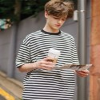

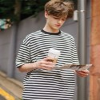

/content/drive/MyDrive/play data final project/img_mu/1_100.jpg : 0.0


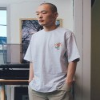

/content/drive/MyDrive/play data final project/img_mu/1_381.jpg : 0.9041631817817688


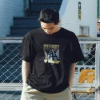

/content/drive/MyDrive/play data final project/img_mu/1_380.jpg : 0.9267752170562744


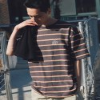

/content/drive/MyDrive/play data final project/img_mu/1_395.jpg : 0.960203230381012


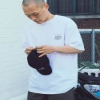

/content/drive/MyDrive/play data final project/img_mu/1_375.jpg : 0.9674617648124695


In [ ]:
# 무신사 검색대상을 보여주자.
query = "/content/drive/MyDrive/play data final project/img_mu/1_100.jpg" 
result = match_mu(query)
cv2_imshow(cv2.resize(cv2.imread(query), (100,100)))
display(result)


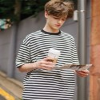

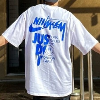

/content/drive/MyDrive/play data final project/insta_imgcrop/img511_b2_c0.jpg : 1.0456898212432861


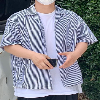

/content/drive/MyDrive/play data final project/insta_imgcrop/img1276_b1_c0.jpg : 1.0472452640533447


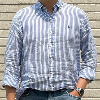

/content/drive/MyDrive/play data final project/insta_imgcrop/img777_b1_c0.jpg : 1.0638033151626587


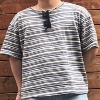

/content/drive/MyDrive/play data final project/insta_imgcrop/img687_b1_c0.jpg : 1.0641030073165894


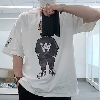

/content/drive/MyDrive/play data final project/insta_imgcrop/img1342_b1_c0.jpg : 1.0658321380615234


In [ ]:
# 인스타 검색대상을 보여주자.
query = "/content/drive/MyDrive/play data final project/img_mu/1_100.jpg" 
result = match_insta(query)
cv2_imshow(cv2.resize(cv2.imread(query), (100,100)))
display(result)


In [ ]:
import os 
import glob # 파일을 찾아주는것 

def match_pair(fn) :
  fn_dir, fn_name = os.path.split(fn)
  new_name = fn_name.split('_')[0] + '_' + fn_name.split('_')[1] #0번지 같은것 과 1번지 같은 것 만 챙겨오자.

  result = [[v, 1 if fn_name in v else 0] for v in glob.glob(f'{fn_dir}/{new_name}*')]
  for i in range(len(result)) :
    if result[i][0] == fn :
      print(i)
      result.pop(i) #인덱스가 당겨지거나 하지 않기 때문에 정리해야.... 

  print(result)

#내 옷도 같이 나오니까 나중에 한번 더 확인하자. -> 비슷한 옷이 나오면 안되니까 제거한다.
# 클래스로 나눈 옷들을 분리해서 바지를 넣으면 상의가 나오게 변경해야 한다. 
# C:하의 B:상의

In [ ]:
# 통합을 하자.
# target 무신사옷, target -> insta /insta-> insta /insta-> musinsa
target = "/content/drive/MyDrive/play data final project/img_mu/1_191.jpg"
result = match_insta(target)
# display(result)
# print("*"*100)
result = match_pair(result[0][0])
# display(result)
# print("*"*100)
result1 =[]
for fn, score in result:
  if score == 1 :
    continue
  result1 += match_mu(fn)
result1 = sorted(result1 , key = lambda item: item[1])  

display(result1[:5]) 


[]


TypeError: ignored